In [24]:
# import standard packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import anndata as ad

# import single-cell packages
import scanpy as sc
#import squidpy as sq

#from spatialdata_io import merscope #spatialdata reader

from pathlib import Path

# set verbosity levels
sc.settings.verbosity = 2

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from typing import List
from scipy.stats import spearmanr
from scipy.special import logit

In [2]:
sys.path.insert(0, "../")

from paths import DATA_DIR, RESULTS_DIR, FIG_DIR, GABITTO_DIR
from colors import AREA_COLOR
RESULTS_DIR = Path(RESULTS_DIR, 'seaad')
FIG_DIR = Path(FIG_DIR, 'seaad')
sc.settings.figdir = str(FIG_DIR)

In [3]:
from utils.qc import plot_qc_joint, get_qc_metrics, plot_scattered_boxplot_mito, NUCLEAR_GENE_SET

## Load constants

In [4]:
MTG_snRNA_path = '/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/SEAAD/SEAAD_DLPFC_RNAseq_final-nuclei.2024-02-13.h5ad'
DLPFC_snRNA_path = '/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/SEAAD/SEAAD_MTG_RNAseq_final-nuclei.2024-02-13.h5ad'

In [12]:
disease_ass_markers = {
    "DAO TF" : ["SOCS3", "HOPX", "FOSB"],
    "DAO_ARO": ["SERPINA3",  "KLK6"],
    "GO_immune": ["STAT1", "B2M"],
    "GO cholesterol": ["FMO5", "FDFT1"],
}

## Load Data 

In [5]:
adata_mtg = sc.read_h5ad(MTG_snRNA_path)
adata_mtg

AnnData object with n_obs × n_vars = 1395601 × 36601
    obs: 'sample_id', 'Neurotypical reference', 'Donor ID', 'Organism', 'Brain Region', 'Sex', 'Gender', 'Age at Death', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino', 'Highest level of education', 'Years of education', 'PMI', 'Fresh Brain Weight', 'Brain pH', 'Overall AD neuropathological Change', 'Thal', 'Braak', 'CERAD score', 'Overall CAA Score', 'Highest Lewy Body Disease', 'Total Microinfarcts (not observed grossly)', 'Total microinfarcts in screening sections', 'Atherosclerosis', 'Arteriolosclerosis', 'LATE', 'Cognitive Status', 'Last CASI Score', 'Interval from last CASI in months', 'Last MMSE Score', 'Interval from last MMSE in months', 'Last MOCA Score', 'Interval from last MOCA in mo

In [13]:
print(adata_mtg.X[:20, :10])

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 2 stored elements and shape (20, 10)>
  Coords	Values
  (10, 6)	0.2795140743255615
  (11, 6)	0.6146668791770935


In [5]:
adata_pfc = sc.read_h5ad(DLPFC_snRNA_path)
adata_pfc

AnnData object with n_obs × n_vars = 1378211 × 36601
    obs: 'sample_id', 'Neurotypical reference', 'Donor ID', 'Organism', 'Brain Region', 'Sex', 'Gender', 'Age at Death', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino', 'Highest level of education', 'Years of education', 'PMI', 'Fresh Brain Weight', 'Brain pH', 'Overall AD neuropathological Change', 'Thal', 'Braak', 'CERAD score', 'Overall CAA Score', 'Highest Lewy Body Disease', 'Total Microinfarcts (not observed grossly)', 'Total microinfarcts in screening sections', 'Atherosclerosis', 'Arteriolosclerosis', 'LATE', 'Cognitive Status', 'Last CASI Score', 'Interval from last CASI in months', 'Last MMSE Score', 'Interval from last MMSE in months', 'Last MOCA Score', 'Interval from last MOCA in mo

## Clean up data

In [6]:
obs_race = ['Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino', 'Highest level of education', 'Years of education']

In [10]:
def clean_obs(adata, obs_columns):
    columns_to_drop = [col for col in obs_columns if col in adata.obs.columns]
    return adata.obs.drop(columns=columns_to_drop)

In [ ]:
#adata_mtg.obs = clean_obs(adata_mtg, obs_race)

In [11]:
adata_pfc.obs = clean_obs(adata_pfc, obs_race)

In [24]:
print(np.unique(adata_mtg.obs['Brain Region']), np.unique(adata_pfc.obs['Brain Region']))

array(['Human DFC_all_layers'], dtype=object)

In [28]:
adata_mtg.obs['brain_region'] = 'TC'
del adata_mtg.obs['Brain Region']

In [12]:
adata_pfc.obs['brain_region'] = 'PFC'
del adata_pfc.obs['Brain Region']

## MT and Nuclear fraction

### MTG 

In [11]:
adata_mtg.var["mt"] = adata_mtg.var_names.str.startswith("MT-")
adata_mtg.var["nuclear"] = adata_mtg.var_names.isin(NUCLEAR_GENE_SET)

In [12]:
sc.pp.calculate_qc_metrics(
    adata_mtg, qc_vars=["mt","nuclear"], inplace=True, percent_top=[20], log1p=True
)

In [34]:
adata_mtg.write('/lustre/groups/ml01/projects/2023_ad_jaekel/gabitto25/SEAAD_MTG_RNAseq_final-nuclei.h5ad')

In [5]:
adata_mtg = sc.read_h5ad('/lustre/groups/ml01/projects/2023_ad_jaekel/gabitto25/SEAAD_MTG_RNAseq_final-nuclei.h5ad')
adata_mtg

/ictstr01/groups/ml01/workspace/francesca.drummer/mamba/envs/compositional/lib/python3.13/site-packages/scanpy/plotting/_anndata.py:967: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/ictstr01/groups/ml01/workspace/francesca.drummer/mamba/envs/compositional/lib/python3.13/site-packages/scanpy/plotting/_anndata.py:967: UserWarning: 
The palette list has fewer values (1) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(
/ictstr01/groups/ml01/workspace/francesca.drummer/mamba/envs/compositional/lib/python3.13/site-packages/scanpy/plotting/_anndata.py:967: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/ictstr01/groups/ml01/workspace/francesca.

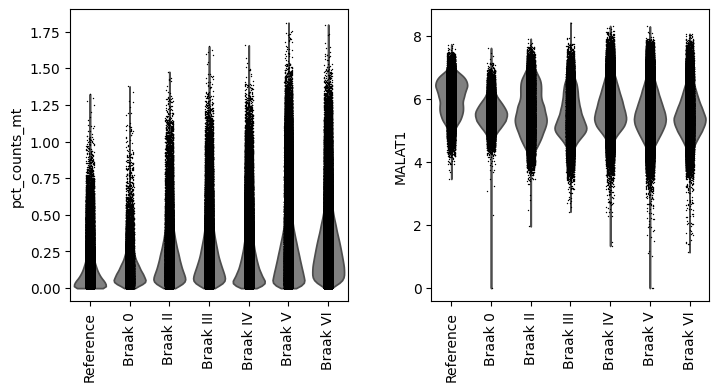

In [14]:
plt.rcParams['figure.figsize']= (4, 4)

sc.pl.violin(adata_mtg, 
             keys=['pct_counts_mt', 'MALAT1'], 
             groupby='Braak', 
             rotation=90, 
             palette=['gray'],
            #save = '_mt_fraction_per_braak_stage.png'
    )

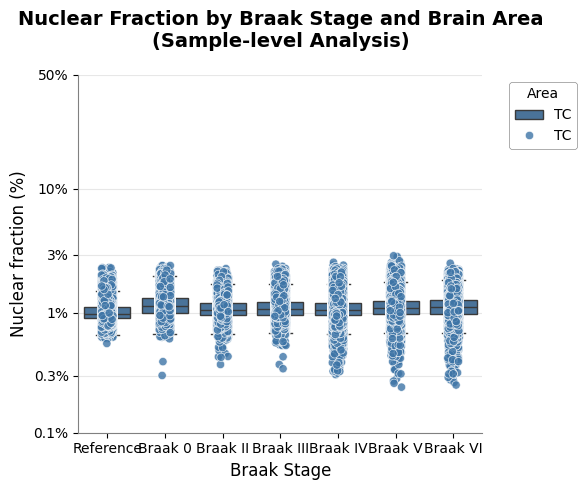

In [33]:
count_col = 'total_counts_nuclear'
sample_col='sample_id'
group_col='Braak'
hue_col = 'brain_region'
colors=AREA_COLOR

if 'mt' in count_col:
    name = 'Mitochondrial'
    abbr = 'mito'
else:
    name = 'Nuclear'
    abbr = 'nuclear'

# Aggregate data at sample level
sample_data = adata_mtg.obs.groupby(sample_col).agg({
    count_col: 'sum',
    'total_counts': 'sum', 
    group_col: 'first',
    hue_col: 'first'
}).reset_index()

# Calculate logit transformation
sample_data['logit_mito'] = logit((sample_data[count_col] + 1) / 
                                 (sample_data['total_counts'] + 2))

# Create plot
fig, ax = plt.subplots(figsize=(6, 5))

# Your exact working code:
sns.boxplot(data=sample_data, x=group_col, y='logit_mito', hue=hue_col, 
            palette=colors, ax=ax, showfliers=False)

# Add scattered dots
sns.stripplot(data=sample_data, x=group_col, y='logit_mito', hue=hue_col,
             palette=colors, size=6, alpha=0.8, ax=ax, dodge=True,
             edgecolor='white', linewidth=0.5)

# Custom y-axis with percentage labels
tick_positions = logit(np.array([0.001, 0.003, 0.01, 0.03, 0.1, 0.5]))
tick_labels = ["0.1%", "0.3%", "1%", "3%", "10%", "50%"]
ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels)

# Labels and styling to match previous boxplot style
ax.set_xlabel("Braak Stage", fontsize=12)
ax.set_ylabel(f"{name} fraction (%)", fontsize=12)

# Add grid for better readability (like previous plots)
ax.grid(True, alpha=0.3, axis='y')
ax.set_axisbelow(True)

# Style legend to match previous plots
legend = ax.get_legend()
if legend:
    legend.set_title('Area')
    legend.set_bbox_to_anchor((1.05, 1))
    legend.set_loc('upper left')
    # Make legend frame more subtle
    legend.get_frame().set_alpha(0.9)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('gray')
    legend.get_frame().set_linewidth(0.5)

# Set title to match previous style
ax.set_title(f'{name} Fraction by Braak Stage and Brain Area\n(Sample-level Analysis)', 
            fontsize=14, fontweight='bold', pad=20)

# Style the plot to match previous scattered boxplots
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')

plt.tight_layout()

plt.savefig(Path(FIG_DIR, f'scattered_boxplot_{abbr}_braak_MTG.png'), dpi=300, bbox_inches='tight')

In [ ]:
fig, ax, sample_data = plot_scattered_boxplot_mito(
    adata_mtg, 
    count_col = 'total_counts_mt',
    sample_col='sample_id',
    group_col='Braak',
    
    figsize=(6, 5),
    save_path=Path(FIG_DIR, 'scattered_boxplot_mito_braak_MTG.png')
)
plt.show()

### DLPFC

In [13]:
adata_pfc.var["mt"] = adata_pfc.var_names.str.startswith("MT-")
adata_pfc.var["nuclear"] = adata_pfc.var_names.isin(NUCLEAR_GENE_SET)

In [14]:
sc.pp.calculate_qc_metrics(
    adata_pfc, qc_vars=["mt","nuclear"], inplace=True, percent_top=[20], log1p=True
)

In [15]:
adata_pfc.write('/lustre/groups/ml01/projects/2023_ad_jaekel/gabitto25/SEAAD_PFC_RNAseq_final-nuclei.h5ad')

/ictstr01/groups/ml01/workspace/francesca.drummer/mamba/envs/compositional/lib/python3.13/site-packages/scanpy/plotting/_anndata.py:967: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/ictstr01/groups/ml01/workspace/francesca.drummer/mamba/envs/compositional/lib/python3.13/site-packages/scanpy/plotting/_anndata.py:967: UserWarning: 
The palette list has fewer values (1) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(
/ictstr01/groups/ml01/workspace/francesca.drummer/mamba/envs/compositional/lib/python3.13/site-packages/scanpy/plotting/_anndata.py:967: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/ictstr01/groups/ml01/workspace/francesca.

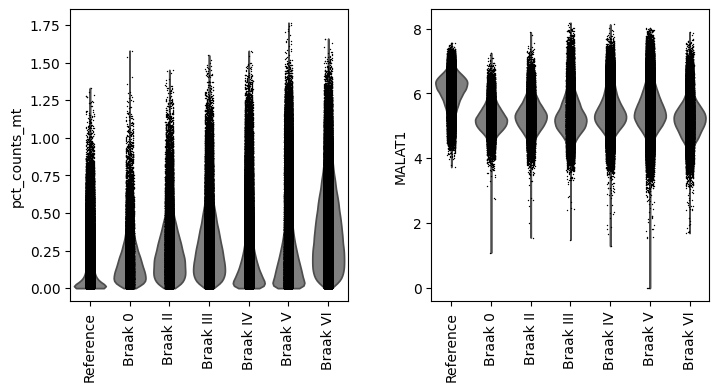

In [7]:
plt.rcParams['figure.figsize']= (4, 4)

sc.pl.violin(adata_pfc, 
             keys=['pct_counts_mt', 'MALAT1'], 
             groupby='Braak', 
             rotation=90, 
             palette=['gray'],
            #save = '_mt_fraction_per_braak_stage.png'
    )

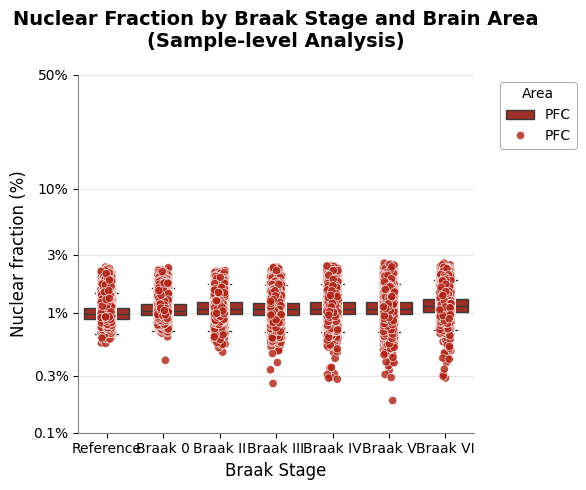

In [17]:
count_col = 'total_counts_nuclear'
sample_col='sample_id'
group_col='Braak'
hue_col = 'brain_region'
colors=AREA_COLOR

fig, ax, sample_data = plot_scattered_boxplot_mito(
    adata_pfc, 
    count_col = 'total_counts_nuclear',
    sample_col='sample_id',
    group_col='Braak',
    hue_col = 'brain_region',
    figsize=(6, 5),
    save_path=Path(FIG_DIR, 'scattered_boxplot_nuclear_braak_PFC.png')
)
plt.show()

## Disease associated oligos

In [18]:
disease_ass_markers = {
    "DAO TF" : ["SOCS3", "HOPX", "FOSB"],
    "DAO_ARO": ["SERPINA3",  "KLK6"],
    "GO_immune": ["STAT1", "B2M"],
    "GO cholesterol": ["FMO5", "FDFT1"],
}

# MTG

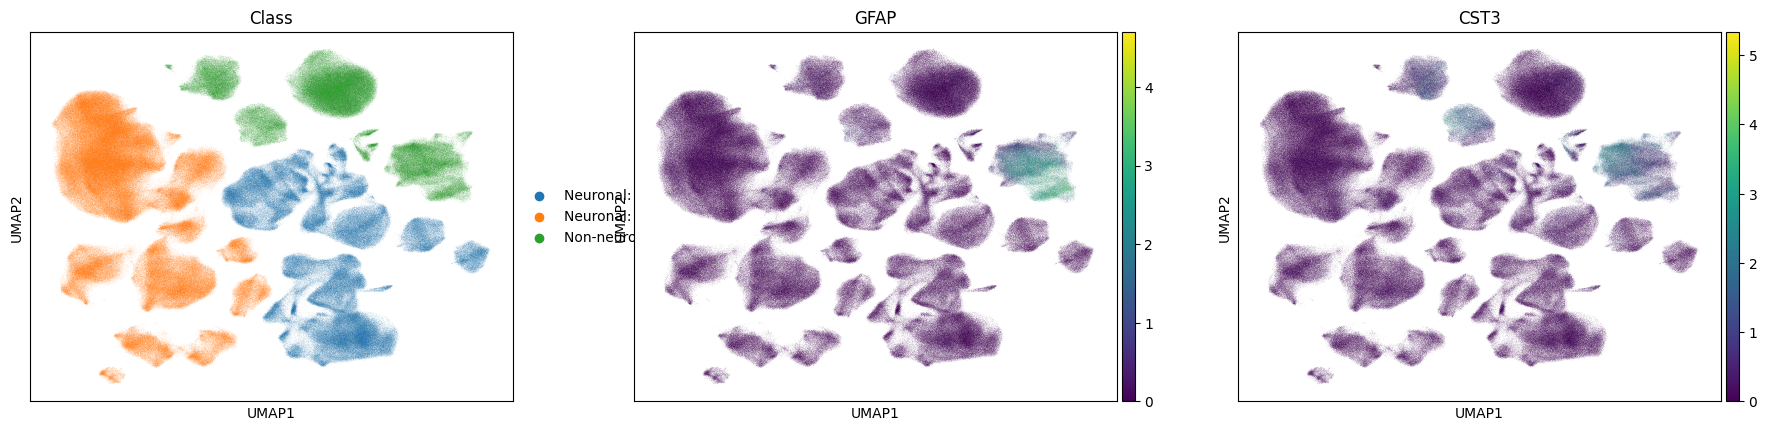

In [6]:
sc.pl.umap(
    adata_mtg,
    color=['Class', 'GFAP', 'CST3'],
    save = '_amyloid_markers.png'
)

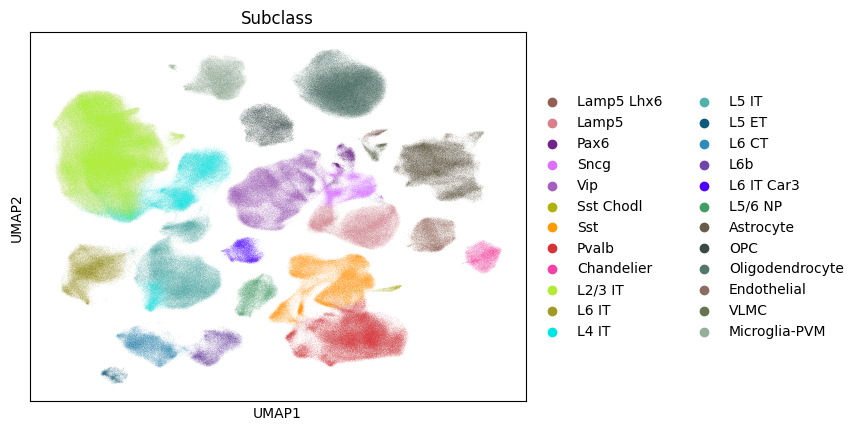

In [10]:
sc.pl.umap(
    adata_mtg,
    color=['Subclass'],
    save = '_subclass.png'
)

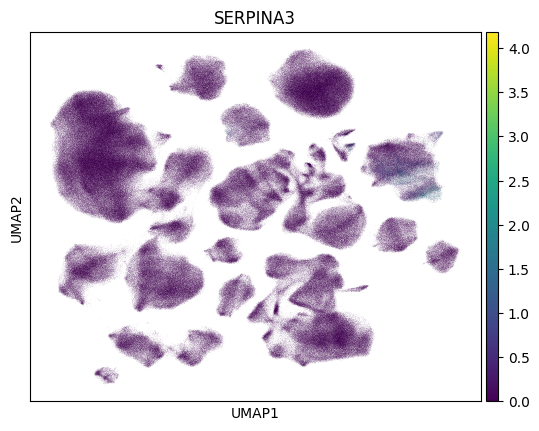

In [9]:
sc.pl.umap(
    adata_mtg,
    color=['SERPINA3'],
    save = '_serpina3_markers.png'
)

In [16]:
adata_oligo = adata_mtg[adata_mtg.obs['Subclass'] == 'Oligodendrocyte']
len(adata_oligo)

145995

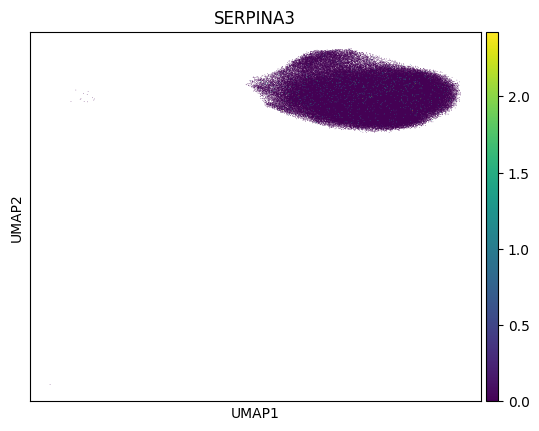

In [19]:
sc.pl.umap(
    adata_oligo,
    color=['SERPINA3'],
    save = '_serpina3_in_oligo.png'
)

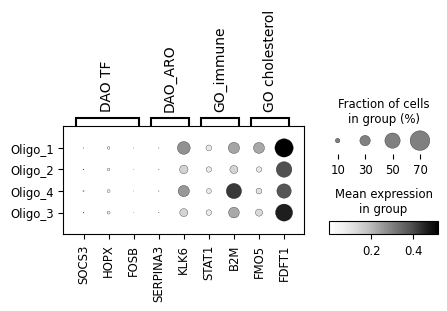

In [18]:
sc.pl.dotplot(adata_oligo, disease_ass_markers, groupby='Supertype', cmap = 'Greys', log = True, save='dao_dotplot_leiden.png')

## DLPFC

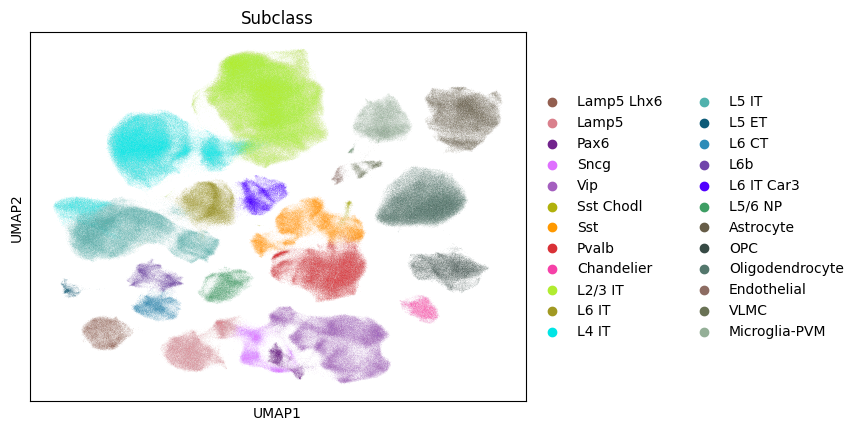

In [19]:
sc.pl.umap(
    adata_pfc,
    color=['Subclass'],
    save = '_subclass_PFC.png'
)

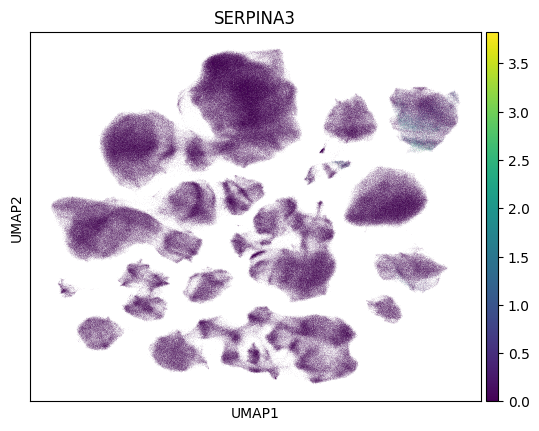

In [20]:
sc.pl.umap(
    adata_pfc,
    color=['SERPINA3'],
    save = '_serpina3_markers_PFC.png'
)

In [22]:
adata_pfc_oligo = adata_pfc[adata_pfc.obs['Subclass'] == 'Oligodendrocyte']
len(adata_pfc_oligo)

111194

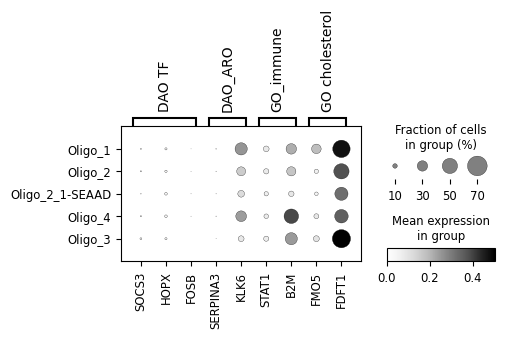

In [23]:
sc.pl.dotplot(adata_pfc_oligo, disease_ass_markers, groupby='Supertype', cmap = 'Greys', log = True, save='dao_dotplot_leiden_PFC.png')